In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.python.keras.layers import Lambda;
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop,Adam, SGD, Adagrad
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from PIL import Image

# Path to your dataset directory (update this to your actual dataset path)
dataset_directory = '/content/drive/MyDrive/diabetic-retinopathy-dataset'

# List to store image sizes
image_sizes = []

# Loop through all files in the directory and its subdirectories
for root, dirs, files in os.walk(dataset_directory):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image file extensions
            file_path = os.path.join(root, file)

            # Open the image
            with Image.open(file_path) as img:
                # Get the size of the image (width, height)
                width, height = img.size
                image_sizes.append((file, width, height))
                print(f"Image: {file} | Size: {width} x {height} pixels")

# Optionally, print the sizes of all images at the end
print("All image sizes:")
for img_info in image_sizes:
    print(f"Image: {img_info[0]} | Size: {img_info[1]} x {img_info[2]} pixels")

Streaming output truncated to the last 5000 lines.
Image: Healthy_255.png | Size: 256 x 256 pixels
Image: Healthy_337.png | Size: 256 x 256 pixels
Image: Healthy_268.png | Size: 256 x 256 pixels
Image: Healthy_254.png | Size: 256 x 256 pixels
Image: Healthy_223.png | Size: 256 x 256 pixels
Image: Healthy_310.png | Size: 256 x 256 pixels
Image: Healthy_232.png | Size: 256 x 256 pixels
Image: Healthy_24.png | Size: 256 x 256 pixels
Image: Healthy_30.png | Size: 256 x 256 pixels
Image: Healthy_249.png | Size: 256 x 256 pixels
Image: Healthy_334.png | Size: 256 x 256 pixels
Image: Healthy_3.png | Size: 256 x 256 pixels
Image: Healthy_293.png | Size: 256 x 256 pixels
Image: Healthy_270.png | Size: 256 x 256 pixels
Image: Healthy_308.png | Size: 256 x 256 pixels
Image: Healthy_294.png | Size: 256 x 256 pixels
Image: Healthy_284.png | Size: 256 x 256 pixels
Image: Healthy_297.png | Size: 256 x 256 pixels
Image: Healthy_259.png | Size: 256 x 256 pixels
Image: Healthy_282.png | Size: 256 x 256 

In [ ]:
import cv2
import os
from PIL import Image
import numpy as np

# Path to your dataset directory
dataset_directory = '/content/drive/MyDrive/diabetic-retinopathy-dataset'

# Preprocessing function: Resize and Normalize
def preprocess_image(image, target_size=(224, 224)):
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0 # min max normalization
    return image_normalized

preprocessed_images = []
# Loop through all files in the directory and its subdirectories
for root, dirs, files in os.walk(dataset_directory):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image file extensions
            file_path = os.path.join(root, file)

            # Open the image using PIL
            img = Image.open(file_path)

            # Convert the PIL Image to a NumPy array
            img_array = np.array(img)

            # Preprocess the image
            preprocessed_image = preprocess_image(img_array)

            # Add the preprocessed image to the list
            preprocessed_images.append(preprocessed_image)

# Display the shape of the first preprocessed image to verify the preprocessing
if preprocessed_images:
  print(f"Shape of preprocessed image: {preprocessed_images[0].shape}")

Shape of preprocessed image: (224, 224, 3)


In [ ]:
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder):
        print(f"Currently searching in: {root}")  # Add this line to check folders
        for filename in files:
            file_path = os.path.join(root, filename)
            img = cv2.imread(file_path)
            if img is not None:
                images.append(img)
    return images

Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset
Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset/Mild DR
Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset/Healthy
Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset/Moderate DR
Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset/Severe DR
Currently searching in: /content/drive/MyDrive/diabetic-retinopathy-dataset/Proliferate DR


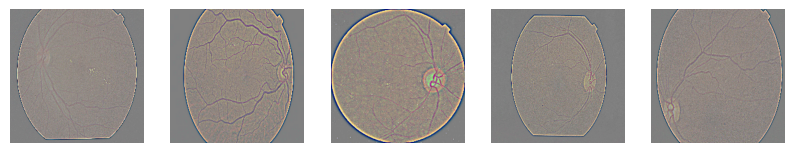

In [ ]:
import matplotlib.pyplot as plt

# Function to display sample images
def display_sample_images(images, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')
    plt.show()

# Load images from the folder (replace 'path/to/your/folder' with the actual path)
images = load_images_from_folder('/content/drive/MyDrive/diabetic-retinopathy-dataset')

# Display 5 sample images
display_sample_images(images)

In [ ]:
import os
import shutil
import random
from glob import glob

def split_data(source_dir, output_dir, train_ratio=0.7, test_ratio=0.3):
    """
    Split images into train and test sets.

    Parameters:
    - source_dir: Root directory containing subfolders (one for each class).
    - output_dir: Root directory where train and test folders will be created.
    - train_ratio: Proportion of images for training set.
    - test_ratio: Proportion of images for test set.
    """

    # Ensure that the split ratios sum to 1
    assert train_ratio + test_ratio == 1, "Split ratios must sum to 1!"

    # Create output directories for train and test splits
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    for folder in [train_dir, test_dir]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Get subfolders in the source directory (assuming each subfolder is a class)
    class_folders = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # Loop through each class folder
    for class_folder in class_folders:
        # Path to the current class folder
        class_folder_path = os.path.join(source_dir, class_folder)

        # Create corresponding class folders in train and test directories
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

        # Get all image file paths in the current class folder
        image_paths = glob(os.path.join(class_folder_path, '*'))

        # Shuffle image paths to ensure random splitting
        random.shuffle(image_paths)

        # Calculate the number of images for each split
        total_images = len(image_paths)
        train_count = int(train_ratio * total_images)

        # Split the images
        train_images = image_paths[:train_count]
        test_images = image_paths[train_count:]

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(train_dir, class_folder, os.path.basename(img_path)))

        for img_path in test_images:
            shutil.copy(img_path, os.path.join(test_dir, class_folder, os.path.basename(img_path)))

        print(f'Successfully split {class_folder}: {train_count} train, {len(test_images)} test images.')

if __name__ == "__main__":
    # Import and mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the source folder containing the class folders
    source_folder = "/content/drive/MyDrive/diabetic-retinopathy-dataset"

    # Define the output folder where train and test splits will be saved
    output_folder = "/content/drive/MyDrive/major project output"

    # Call the function to split the dataset
    split_data(source_folder, output_folder, train_ratio=0.7, test_ratio=0.3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully split Mild DR: 259 train, 111 test images.
Successfully split Healthy: 700 train, 300 test images.
Successfully split Moderate DR: 630 train, 270 test images.
Successfully split Severe DR: 133 train, 57 test images.
Successfully split Proliferate DR: 203 train, 87 test images.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load the file paths from the text files
with open('train_files.txt', 'r') as f:
    train_files = f.read().splitlines()

with open('test_files.txt', 'r') as f:
    test_files = f.read().splitlines()

# Parameters
batch_size = 32
img_size = (224, 224)  # Change this as per your input size

# Define the ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1/255.)

# Custom generator to yield batches of images and labels
def custom_data_generator(file_paths, batch_size, img_size, datagen):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_files = file_paths[i:i+batch_size]
            env_images = []

            for file_path in batch_files:
                img = load_img(file_path, target_size=img_size)  # Load image
                img = img_to_array(img)  # Convert image to array
                env_images.append(img)  # Append to batch list

            # Preprocess images using ImageDataGenerator
            batch_images = np.array(env_images)
            batch_images = datagen.flow(batch_images, batch_size=batch_size, shuffle=False).next()

            # Yield the batch (you can also yield labels if you have them, e.g., class labels)
            yield batch_images, None  # Replace `None` with actual labels if available

# Example usage for training data generator
train_generator = custom_data_generator(train_files, batch_size, img_size, datagen)

# Example usage for testing data generator
test_generator = custom_data_generator(test_files, batch_size, img_size, datagen)


In [ ]:
#train = ImageDataGenerator(rescale= 1/255, )
#test = ImageDataGenerator(rescale= 1/255)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Define the paths to your directories
train_dir = '/content/drive/MyDrive/major project output/train'
test_dir = '/content/drive/MyDrive/major project output/test'

# Load images from directories using ImageDataGenerator
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)


Found 2750 images belonging to 5 classes.
Found 2743 images belonging to 5 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (3, 3), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape=(224, 224, 3))


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 114, 114, 64)   │          1,792 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 114, 114, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_49             │ (None, 114, 114, 64)   │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ activation_49[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 56, 56, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 56, 56, 64)     │              0 │ bn2a_branch2a[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 56, 56, 64)     │         36,928 │ activation_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 56, 56, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_51             │ (None, 56, 56, 64)     │              0 │ bn2a_branch2b[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 56, 56, 256)    │         16,640 │ activation_51[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 56, 56, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization) 

 Total params: 23,580,032 (89.95 MB)

 Trainable params: 23,526,912 (89.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
!apt-get install graphviz
!pip install graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!dot -V


dot - graphviz version 2.43.0 (0)


In [ ]:
# Export the model to JSON
model_json = model.to_json()

# Save the JSON to a file
with open("resnet50_model.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture has been saved as 'resnet50_model.json'")


Model architecture has been saved as 'resnet50_model.json'


In [ ]:
pip install tensorflow

In [ ]:

base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 5,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
#headModel=Dense(128, activation='relu',name='fc4', kernel_regularizer=regularizers.l2(0.01))(headModel) # Changed headmodel to headModel
#headModel = Dense( 5,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
#headModel=Dense(128, activation='relu',name='fc4', kernel_regularizer=regularizers.l2(0.01))(headmodel)

In [ ]:
from tensorflow.keras.models import Sequential, Model,load_model
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 114, 114, 64)   │          1,792 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 114, 114, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 114, 114, 64)   │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 56, 56, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 56, 56, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 56, 56, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 56, 56, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 32,002,437 (122.08 MB)

 Trainable params: 31,949,317 (121.88 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'])
model_fit = model.fit(train_dataset, epochs=20, validation_data= test_dataset)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


688/688 ━━━━━━━━━━━━━━━━━━━━ 2537s 4s/step - accuracy: 0.5186 - loss: 2.3925 - val_accuracy: 0.1834 - val_loss: 2.3558
Epoch 2/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 2487s 4s/step - accuracy: 0.6684 - loss: 0.8539 - val_accuracy: 0.4419 - val_loss: 2.0898
Epoch 3/20
129/688 ━━━━━━━━━━━━━━━━━━━━ 27:11 3s/step - accuracy: 0.7945 - loss: 0.5294

In [ ]:
print(model_fit.history['accuracy'])

[0.5749090909957886, 0.6694545745849609, 0.7232727408409119, 0.7287272810935974, 0.7501817941665649, 0.765818178653717, 0.778181791305542, 0.7930908799171448, 0.7960000038146973, 0.8069090843200684, 0.848727285861969, 0.8640000224113464, 0.8792726993560791, 0.8992727398872375, 0.9210909008979797, 0.930545449256897, 0.9414545297622681, 0.9472727179527283, 0.9465454816818237, 0.9589090943336487, 0.9483636617660522, 0.9683636426925659, 0.9752727150917053, 0.97563636302948, 0.954909086227417]


In [ ]:
print(model_fit.history['val_accuracy'])

[0.601024866104126, 0.36237189173698425, 0.435578316450119, 0.4454612135887146, 0.6123718619346619, 0.43374815583229065, 0.3367496430873871, 0.5322108268737793, 0.4077598750591278, 0.42532941699028015, 0.316617876291275, 0.41398242115974426, 0.314421683549881, 0.3363836109638214, 0.28696924448013306, 0.41251829266548157, 0.3978770077228546, 0.3297950327396393, 0.1844802349805832, 0.416544646024704, 0.37774524092674255, 0.39202049374580383, 0.28294289112091064, 0.2741581201553345, 0.3700585663318634]


In [ ]:
model.save("Resnet_adam.h5")
import tensorflow as tf
model= tf.keras.models.load_model("Resnet_adam.h5")

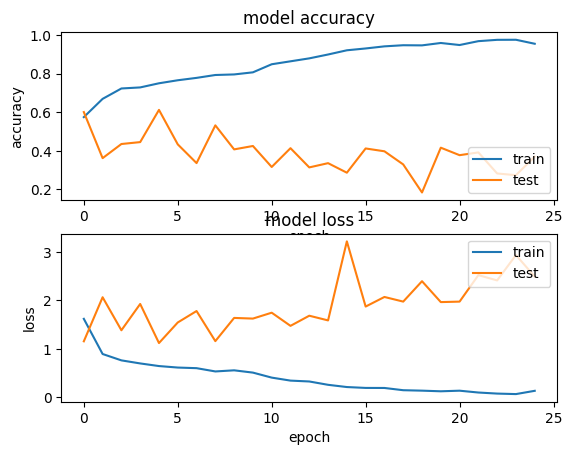

In [ ]:
import os
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
#plotting confusion matrix and print Classification Report
from sklearn.metrics import classification_report
import numpy as np
test_predictions = model.predict(test_dataset)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

from sklearn.metrics import confusion_matrix
confusion_matrix(true_classes, predicted_classes)
print(confusion_matrix(true_classes, predicted_classes))

683/683 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step
                precision    recall  f1-score   support

       Healthy       0.80      0.03      0.05       994
       Mild DR       0.00      0.00      0.00       366
   Moderate DR       0.49      0.81      0.61       894
Proliferate DR       0.20      0.56      0.29       290
     Severe DR       0.29      0.53      0.37       188

      accuracy                           0.37      2732
     macro avg       0.36      0.38      0.27      2732
  weighted avg       0.49      0.37      0.28      2732

[[ 28  52 467 405  42]
 [  6   0 130 123 107]
 [  0   0 721 118  55]
 [  1   0  88 163  38]
 [  0   0  70  19  99]]


683/683 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step


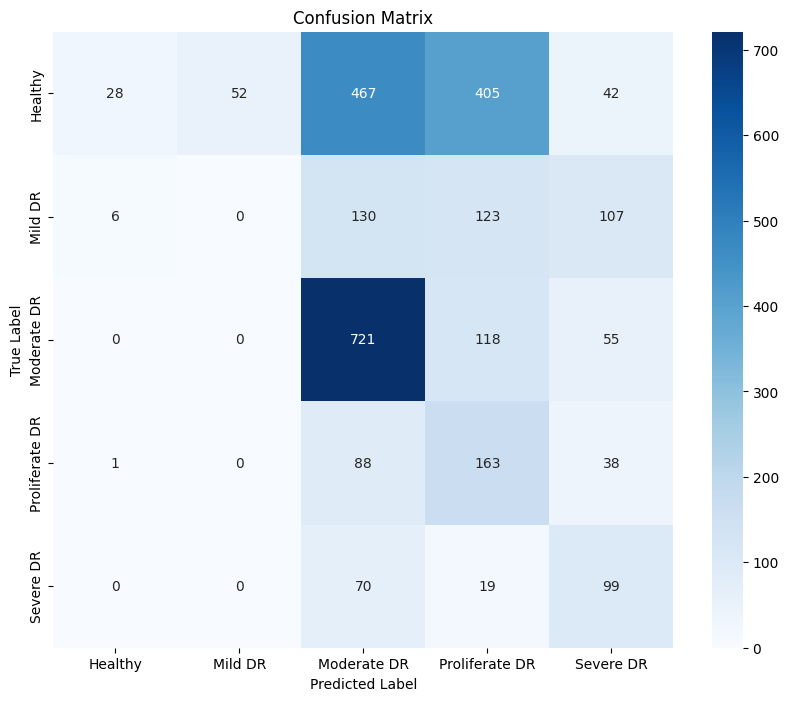

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model
model = tf.keras.models.load_model("Resnet_adam.h5")

# Make predictions on the test dataset
Y_pred = model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_dataset.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
